# GI-Tract Image Segmentation

## Generate 2.5D Data

### by Zhiyin (Steven) Lu

In [1]:
# from google.colab import drive
# drive.mount('/content/drive/')

# %ls

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
from joblib import Parallel, delayed
from tqdm.notebook import tqdm

## Define Functions

In [3]:
# Resize the given image to the target size by adding padding
def resize_image(img, target_size, is_mask=False):
    img_size = img.shape
    x_diff = target_size[0] - img_size[0]
    y_diff = target_size[1] - img_size[1]
    pad_x = (x_diff//2, x_diff//2 + x_diff%2)
    pad_y = (y_diff//2, y_diff//2 + y_diff%2)
    if is_mask:
        img = np.pad(img, [pad_x, pad_y, [0,0]])
    else:
        img = np.pad(img, [pad_x, pad_y])
    return img

# Load a scan image, resize if needed
def load_scan(path, target_size):
    scan = cv2.imread(path, -1)
    if scan.shape != (target_size):
        scan = resize_image(scan, target_size)
    return scan

# Load a mask image, resize if needed
def load_mask(path, target_size):
    mask = np.load(path)
    if mask.shape != target_size:
        mask = resize_image(mask, target_size, is_mask=True)
    return mask

# Combine the scans to generate 2.5d scans
def generate_25d_scan(paths, target_size):
    combined_scans = np.zeros( (*target_size, len(paths)), dtype=np.uint16)
    for i, scan_path in enumerate(paths):
        scan = load_scan(scan_path, target_size)
        combined_scans[:,:,i] += scan
    return combined_scans

# Save the produced scans and resized masks to file
def save_files(id_, target_size, scan_dir, mask_dir):
    row = data[data['id'] == id_].squeeze()
    
    scan_paths = row['scan_list']
    combined_scans = generate_25d_scan(scan_paths, target_size)
    np.save(f'{scan_dir}/{id_}.npy', combined_scans)

    mask_path = row['mask_path']
    resized_mask = load_mask(mask_path, target_size)
    np.save(f'{mask_dir}/{id_}.npy', resized_mask)

## Load Data

In [4]:
# Load data from .csv file
load_dir = './data/data.csv'
data = pd.read_csv(load_dir)

display(data)

,scan_path,mask_path,id,case,day,slice,height,width,segmentation,rle_len,empty
0,./data/scans/train/case101/case101_day20/scans...,./data/masks/train/case101/case101_day20/scans...,case101_day20_slice_0001,101,20,1,266,266,"['', '', '']",0,True
1,./data/scans/train/case101/case101_day20/scans...,./data/masks/train/case101/case101_day20/scans...,case101_day20_slice_0002,101,20,2,266,266,"['', '', '']",0,True
2,./data/scans/train/case101/case101_day20/scans...,./data/masks/train/case101/case101_day20/scans...,case101_day20_slice_0003,101,20,3,266,266,"['', '', '']",0,True
3,./data/scans/train/case101/case101_day20/scans...,./data/masks/train/case101/case101_day20/scans...,case101_day20_slice_0004,101,20,4,266,266,"['', '', '']",0,True
4,./data/scans/train/case101/case101_day20/scans...,./data/masks/train/case101/case101_day20/scans...,case101_day20_slice_0005,101,20,5,266,266,"['', '', '']",0,True
...,...,...,...,...,...,...,...,...,...,...,...
38491,./data/scans/train/case92/case92_day0/scans/sl...,./data/masks/train/case92/case92_day0/scans/sl...,case92_day0_slice_0140,92,0,140,266,266,"['', '', '']",0,True
38492,./data/scans/train/case92/case92_day0/scans/sl...,./data/masks/train/case92/case92_day0/scans/sl...,case92_day0_slice_0141,92,0,141,266,266,"['', '', '']",0,True
38493,./data/scans/train/case92/case92_day0/scans/sl...,./data/masks/train/case92/case92_day0/scans/sl...,case92_day0_slice_0142,92,0,142,266,266,"['', '', '']",0,True
38494,./data/scans/train/case92/case92_day0/scans/sl...,./data/masks/train/case92/case92_day0/scans/sl...,case92_day0_slice_0143,92,0,143,266,266,"['', '', '']",0,True


## Configuration

In [5]:
# Configuration
NUM_CHANNEL = 3
STRIDE = 2
TARGET_SIZE = (320, 320)
SCANS_SAVE_PATH = './2.5d_data/scans'
if not os.path.exists(SCANS_SAVE_PATH):
    os.makedirs(SCANS_SAVE_PATH)
MASKS_SAVE_PATH = './2.5d_data/masks'
if not os.path.exists(MASKS_SAVE_PATH):
    os.makedirs(MASKS_SAVE_PATH)

In [6]:
# Get paths to scans to be combined
scan_set = pd.DataFrame( {'id': data['id']} )
for i in range(NUM_CHANNEL):
    scan_set[f'scan_{i}'] = data.groupby(['case', 'day'])['scan_path'].shift(-STRIDE * i).fillna(method='ffill')
scan_set['scan_list'] = scan_set[ [f'scan_{i}' for i in range(NUM_CHANNEL)] ].values.tolist()
data = data.merge(scan_set, on=['id'])

display(data)

,scan_path,mask_path,id,case,day,slice,height,width,segmentation,rle_len,empty,scan_0,scan_1,scan_2,scan_list
0,./data/scans/train/case101/case101_day20/scans...,./data/masks/train/case101/case101_day20/scans...,case101_day20_slice_0001,101,20,1,266,266,"['', '', '']",0,True,./data/scans/train/case101/case101_day20/scans...,./data/scans/train/case101/case101_day20/scans...,./data/scans/train/case101/case101_day20/scans...,[./data/scans/train/case101/case101_day20/scan...
1,./data/scans/train/case101/case101_day20/scans...,./data/masks/train/case101/case101_day20/scans...,case101_day20_slice_0002,101,20,2,266,266,"['', '', '']",0,True,./data/scans/train/case101/case101_day20/scans...,./data/scans/train/case101/case101_day20/scans...,./data/scans/train/case101/case101_day20/scans...,[./data/scans/train/case101/case101_day20/scan...
2,./data/scans/train/case101/case101_day20/scans...,./data/masks/train/case101/case101_day20/scans...,case101_day20_slice_0003,101,20,3,266,266,"['', '', '']",0,True,./data/scans/train/case101/case101_day20/scans...,./data/scans/train/case101/case101_day20/scans...,./data/scans/train/case101/case101_day20/scans...,[./data/scans/train/case101/case101_day20/scan...
3,./data/scans/train/case101/case101_day20/scans...,./data/masks/train/case101/case101_day20/scans...,case101_day20_slice_0004,101,20,4,266,266,"['', '', '']",0,True,./data/scans/train/case101/case101_day20/scans...,./data/scans/train/case101/case101_day20/scans...,./data/scans/train/case101/case101_day20/scans...,[./data/scans/train/case101/case101_day20/scan...
4,./data/scans/train/case101/case101_day20/scans...,./data/masks/train/case101/case101_day20/scans...,case101_day20_slice_0005,101,20,5,266,266,"['', '', '']",0,True,./data/scans/train/case101/case101_day20/scans...,./data/scans/train/case101/case101_day20/scans...,./data/scans/train/case101/case101_day20/scans...,[./data/scans/train/case101/case101_day20/scan...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38491,./data/scans/train/case92/case92_day0/scans/sl...,./data/masks/train/case92/case92_day0/scans/sl...,case92_day0_slice_0140,92,0,140,266,266,"['', '', '']",0,True,./data/scans/train/case92/case92_day0/scans/sl...,./data/scans/train/case92/case92_day0/scans/sl...,./data/scans/train/case92/case92_day0/scans/sl...,[./data/scans/train/case92/case92_day0/scans/s...
38492,./data/scans/train/case92/case92_day0/scans/sl...,./data/masks/train/case92/case92_day0/scans/sl...,case92_day0_slice_0141,92,0,141,266,266,"['', '', '']",0,True,./data/scans/train/case92/case92_day0/scans/sl...,./data/scans/train/case92/case92_day0/scans/sl...,./data/scans/train/case92/case92_day0/scans/sl...,[./data/scans/train/case92/case92_day0/scans/s...
38493,./data/scans/train/case92/case92_day0/scans/sl...,./data/masks/train/case92/case92_day0/scans/sl...,case92_day0_slice_0142,92,0,142,266,266,"['', '', '']",0,True,./data/scans/train/case92/case92_day0/scans/sl...,./data/scans/train/case92/case92_day0/scans/sl...,./data/scans/train/case92/case92_day0/scans/sl...,[./data/scans/train/case92/case92_day0/scans/s...
38494,./data/scans/train/case92/case92_day0/scans/sl...,./data/masks/train/case92/case92_day0/scans/sl...,case92_day0_slice_0143,92,0,143,266,266,"['', '', '']",0,True,./data/scans/train/case92/case92_day0/scans/sl...,./data/scans/train/case92/case92_day0/scans/sl...,./data/scans/train/case92/case92_day0/scans/sl...,[./data/scans/train/case92/case92_day0/scans/s...


## Generate the Full Dataset

In [7]:
# # Start generating 2.5d data and save files
# ids = data['id'].unique()
# _ = Parallel(n_jobs=-1, backend='threading')(delayed(save_files)(id_, TARGET_SIZE, SCANS_SAVE_PATH, MASKS_SAVE_PATH) for id_ in tqdm(ids, total=len(ids)))

## Generate a Small Batch Only

In [8]:
# Generate a small labeled batch for demonstration purpose
data = data[data['empty'] == False]
ids = data['id'].unique()[:10] # small batch for debug purpose
_ = Parallel(n_jobs=-1, backend='threading')(delayed(save_files)(id_, TARGET_SIZE, SCANS_SAVE_PATH, MASKS_SAVE_PATH) for id_ in tqdm(ids, total=len(ids)))

  0%|          | 0/10 [00:00<?, ?it/s]

DEMONSTRATING: case101_day20_slice_0068
(320, 320, 3)


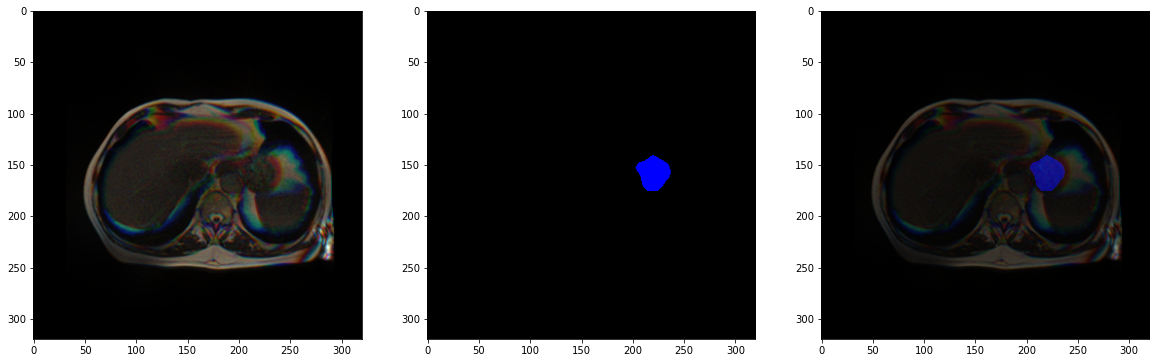

In [9]:
# Demonstration
CASE_NAME = data['id'].reset_index(drop=True)[2]
print(f'DEMONSTRATING: {CASE_NAME}')

scan = np.load(f'{SCANS_SAVE_PATH}/{CASE_NAME}.npy').astype('float32')
scan /= scan.max(axis=(0,1))

mask = np.load(f'{MASKS_SAVE_PATH}/{CASE_NAME}.npy').astype('float32')
mask /= 255.0

print(mask.shape)

plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.imshow(scan)
plt.subplot(1, 3, 2)
plt.imshow(mask)
plt.subplot(1, 3, 3)
plt.imshow(scan)
plt.imshow(mask, alpha=0.5)